In [3]:
import numpy as np
import torch
from alphatoe import plot, game, interpretability
from transformer_lens import HookedTransformer, HookedTransformerConfig
import json
import einops
import circuitsvis as cv
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import matplotlib.pyplot as plt
from importlib import reload
from copy import copy
import pandas as pd
import random
import tqdm

In [4]:
model = interpretability.load_model(
    "../scripts/models/prob all 8 layer control-20230718-185339"
)

In [5]:
def neuron_posembed_activations(seq):
    def hook(module, input, output):
        result = output.clone()
        module.captured_activations = result

    try:
        handle = model.blocks[0].mlp.hook_post.register_forward_hook(hook)
        _ = model.blocks[0].mlp(seq)
        activations = model.blocks[0].mlp.hook_post.captured_activations
        handle.remove()
    except Exception as e:
        handle.remove()
        raise e

    return activations


def neuron_activations(seq):
    def hook(module, input, output):
        result = output.clone()
        module.captured_activations = result

    try:
        handle = model.blocks[0].mlp.hook_post.register_forward_hook(hook)
        _ = model(seq)
        activations = model.blocks[0].mlp.hook_post.captured_activations
        handle.remove()
    except Exception as e:
        handle.remove()
        raise e

    return activations

In [6]:
games = pd.read_csv("../data/prob all 8 layer control-20230718-185339_stats.csv")
games.head()

/tmp/ipykernel_37958/629368561.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  games = pd.read_csv("../data/prob all 8 layer control-20230718-185339_stats.csv")


,moves played,steps till end state,winner,rotation 1,rotation 2,rotation 3,horizontal flip,vertical flip,training index,train or test,first win condition,second win condition,end move loss
0,"[0, 1, 3, 2, 6]",5,X,399,1439,1040,1114,325,241912,test,left column,NaN,0.000005
1,"[0, 1, 3, 4, 6]",5,X,396,1438,1043,1112,327,190522,train,left column,NaN,0.000114
2,"[0, 1, 3, 5, 6]",5,X,398,1437,1041,1113,326,90275,train,left column,NaN,0.000007
3,"[0, 1, 3, 7, 6]",5,X,395,1436,1044,1110,329,21994,train,left column,NaN,0.000008
4,"[0, 1, 3, 8, 6]",5,X,397,1435,1042,1111,328,48696,train,left column,NaN,0.000013


In [7]:
end_game_types = list(games["first win condition"].unique())
print(end_game_types)

['left column', 'top left -> bottom right', 'top row', 'middle column', 'bottom left -> top right', 'right column', 'middle row', 'bottom row', nan]


In [8]:
non_9_move_games = games[games["steps till end state"] != 9]

In [9]:
non_9_move_games

,moves played,steps till end state,winner,rotation 1,rotation 2,rotation 3,horizontal flip,vertical flip,training index,train or test,first win condition,second win condition,end move loss
0,"[0, 1, 3, 2, 6]",5,X,399,1439,1040,1114,325,241912,test,left column,NaN,0.000005
1,"[0, 1, 3, 4, 6]",5,X,396,1438,1043,1112,327,190522,train,left column,NaN,0.000114
2,"[0, 1, 3, 5, 6]",5,X,398,1437,1041,1113,326,90275,train,left column,NaN,0.000007
3,"[0, 1, 3, 7, 6]",5,X,395,1436,1044,1110,329,21994,train,left column,NaN,0.000008
4,"[0, 1, 3, 8, 6]",5,X,397,1435,1042,1111,328,48696,train,left column,NaN,0.000013
...,...,...,...,...,...,...,...,...,...,...,...,...,...
127291,"[8, 7, 6, 5, 2, 4, 0, 3]",8,O,105999,54724,76016,72687,109328,131318,train,middle row,NaN,0.000055
127292,"[8, 7, 6, 5, 2, 4, 1, 3]",8,O,106001,54723,76014,72689,109326,116367,train,middle row,NaN,0.000005
127293,"[8, 7, 6, 5, 2, 4, 3, 1]",8,O,105998,54722,76017,72686,109329,186649,train,middle column,NaN,0.000136
127294,"[8, 7, 6, 5, 3, 1, 2, 4]",8,O,105985,54721,76030,72673,109342,189086,train,middle column,NaN,0.000153


In [10]:
# game_types x game x moves
game_kinds = [
    [
        [10] + eval(move)
        for move in non_9_move_games[
            non_9_move_games["first win condition"] == game_type
        ]["moves played"]
    ]
    for game_type in end_game_types[:-1]
]

In [11]:
# 30 seconds
game_count = 1_000
all_activations = []
for games in game_kinds:
    kind_activations = []
    for _ in range(game_count):
        data = torch.tensor(random.choice(games))
        kind_activations.append(neuron_activations(data)[0][-1])
    all_activations.append(torch.stack(kind_activations))
all_activations = torch.cat(all_activations)
all_activations = all_activations.detach().cpu().T

<Figure size 1000x1000 with 0 Axes>

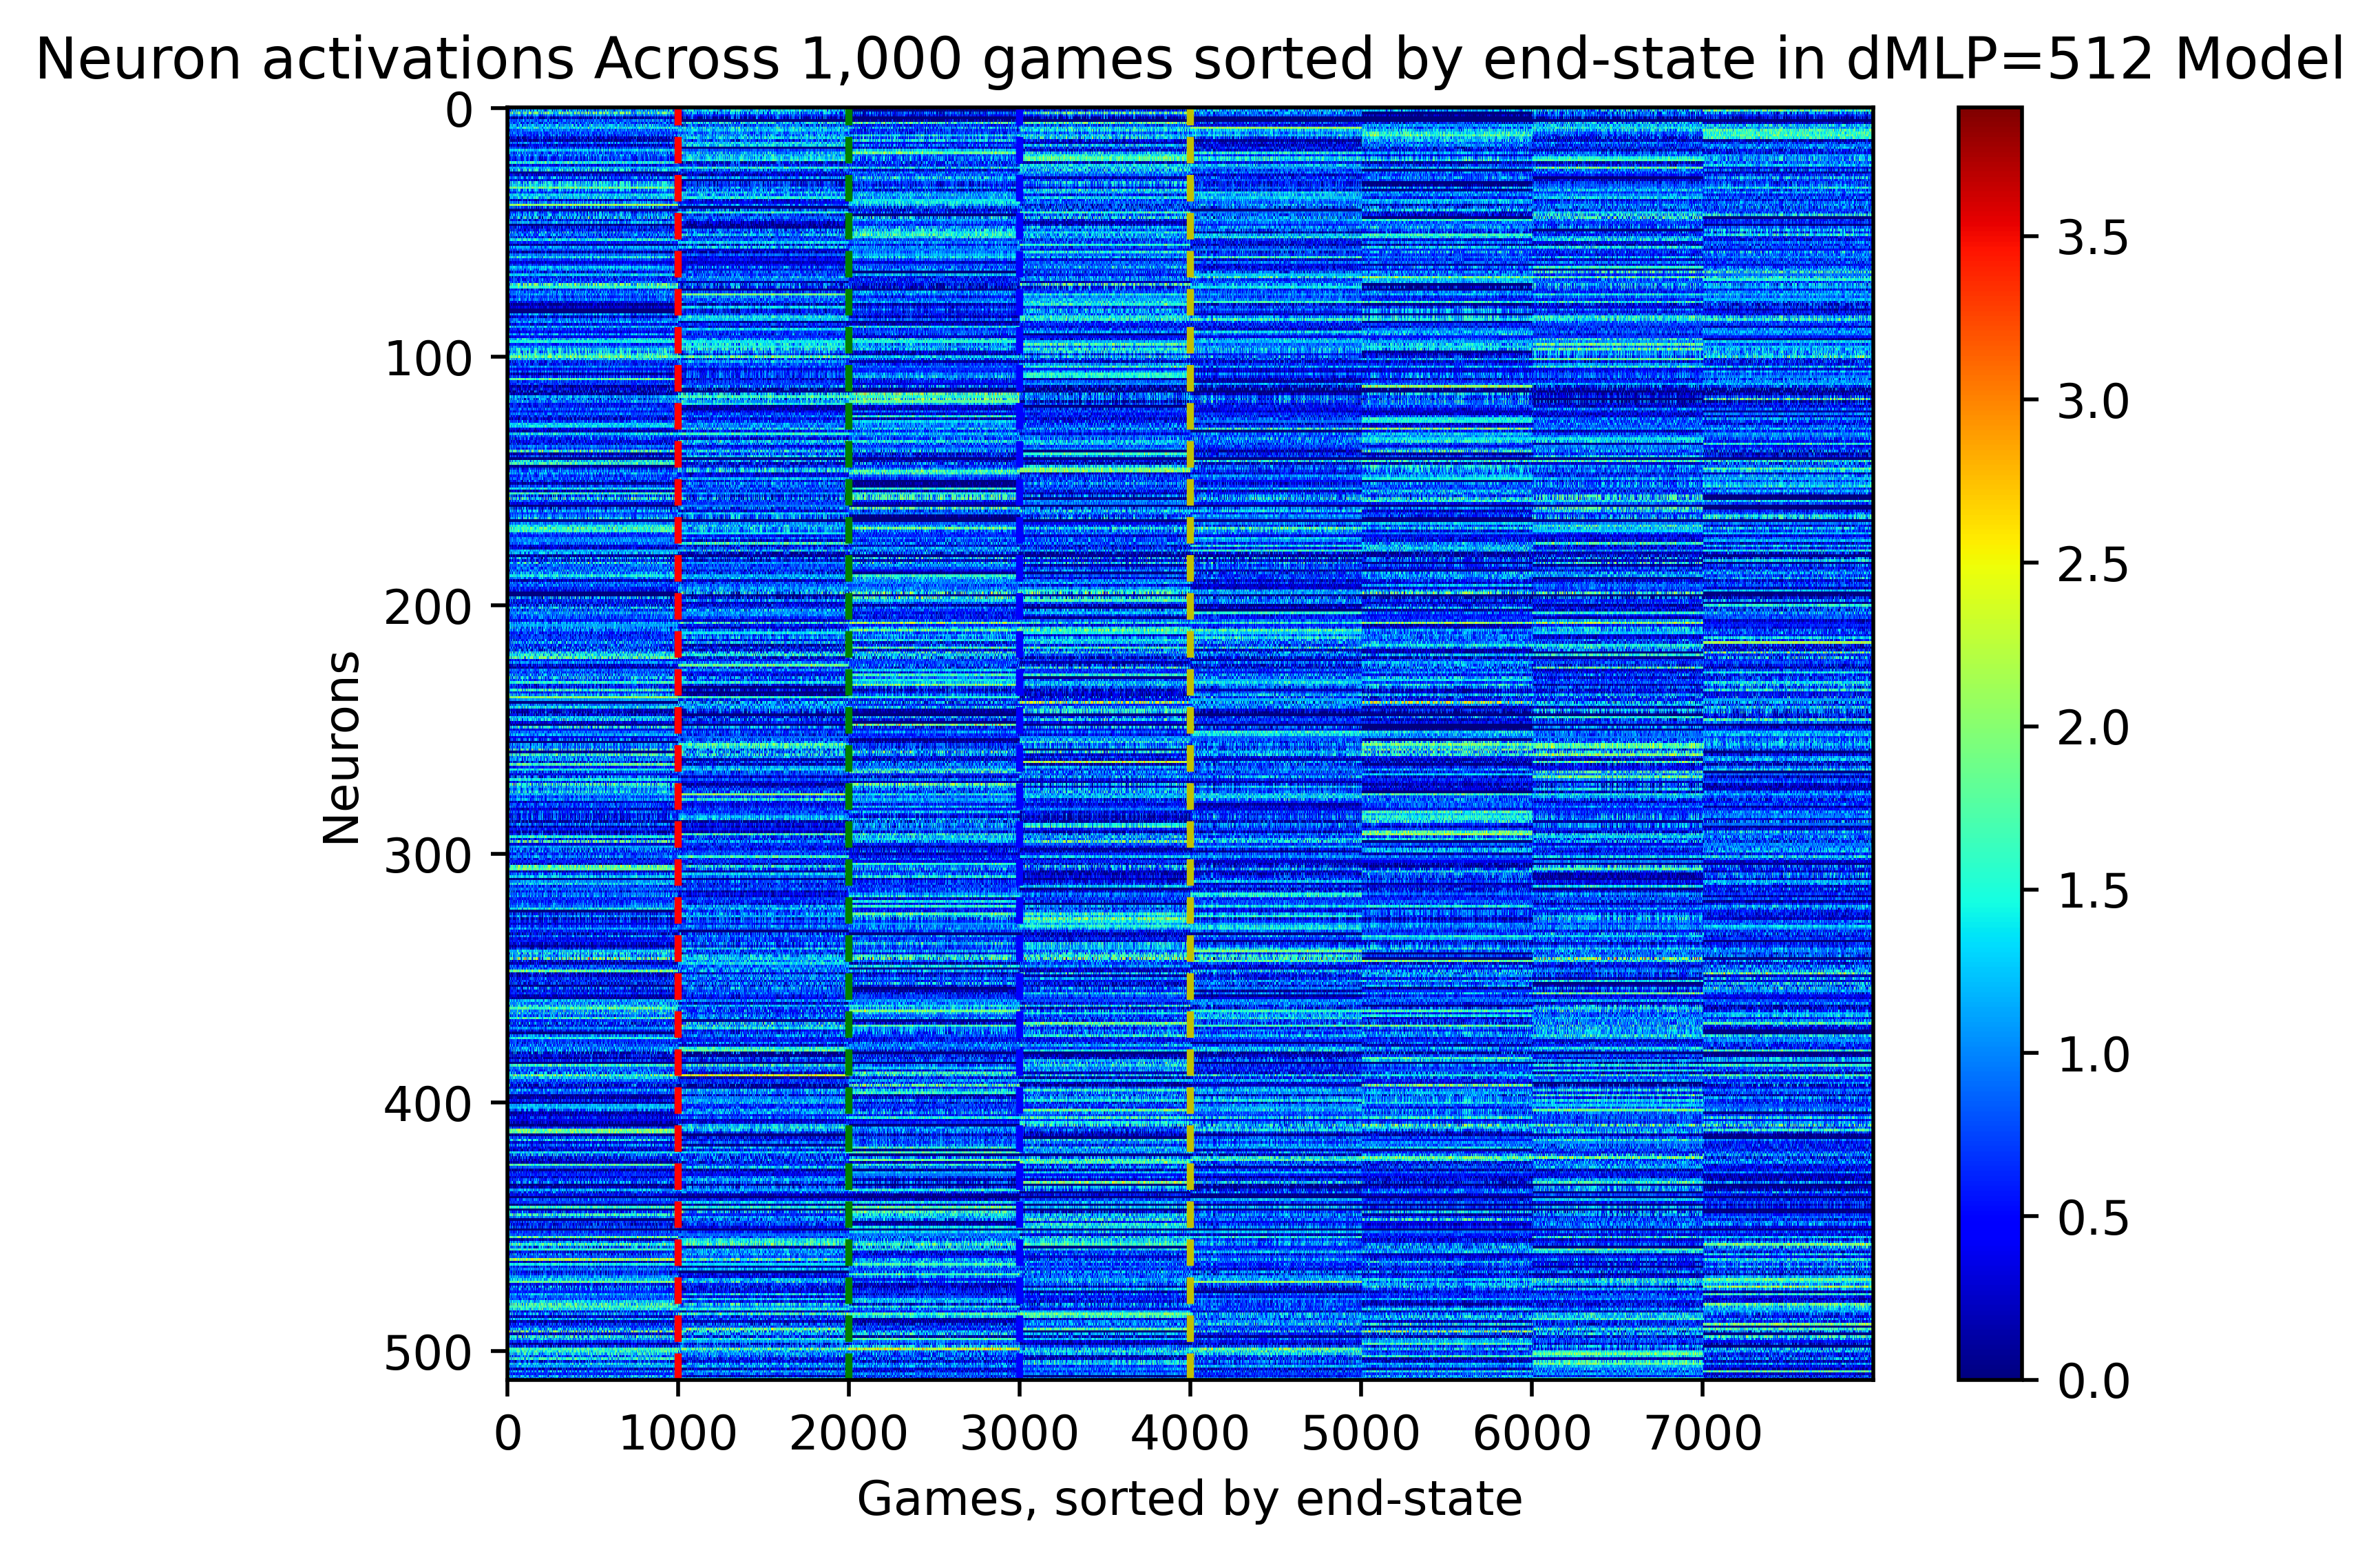

In [12]:
plt.figure(figsize=(10, 10))
# dpi
plt.figure(dpi=500)
plt.imshow(all_activations, cmap="jet", aspect="auto", interpolation="none")
# colorbar
plt.colorbar()

plt.xlabel("Games, sorted by end-state")
plt.ylabel("Neurons")
# title
plt.title(
    "Neuron activations Across 1,000 games sorted by end-state in dMLP=512 Model",
    fontsize=12,
)
plt.gcf().set_facecolor("white")
plt.axvline(x=game_count, color="r", linestyle="--", label="moves till end state 5")
plt.axvline(x=game_count * 2, color="g", linestyle="--", label="moves till end state 6")
plt.axvline(x=game_count * 3, color="b", linestyle="--", label="moves till end state 7")
plt.axvline(x=game_count * 4, color="y", linestyle="--", label="moves till end state 8")

### Find vector that corresponds to the average of the pre-mlp residual stream across across games in a category 

In [13]:
# Find vector that strongly corresponds to each activation per category
# self.hook_resid_mid
def resid_pre_mlp(seq):
    def hook(module, input, output):
        result = output.clone()
        module.captured_residual = result

    try:
        handle = model.blocks[0].hook_resid_mid.register_forward_hook(hook)
        with torch.no_grad():
            _ = model(seq)
        activations = model.blocks[0].hook_resid_mid.captured_residual
        handle.remove()
    except Exception as e:
        handle.remove()
        raise e

    return activations

In [14]:
out = resid_pre_mlp(torch.tensor(game_kinds[0][0]))

### Now find all average vectors

In [15]:
total_games = 0
for games in game_kinds:
    gl = len(games)
    total_games += gl
    print(gl)
print(total_games)

14436
20340
14436
14436
20340
14436
14436
14436
127296


In [16]:
def find_mean_residual_vector(games):
    vectors = []
    for game in tqdm.tqdm(games):
        vectors.append(resid_pre_mlp(torch.tensor(game))[0, -1])

    final_vectors = torch.stack(vectors)
    average_vector = torch.mean(final_vectors, dim=0)
    return average_vector

In [17]:
residual_vectors = {}
for game_type, games in zip(end_game_types[:-1], game_kinds[:-1]):
    residual_vectors[game_type] = find_mean_residual_vector(games).detach().to("cpu")

  4%|▍         | 643/14436 [00:00<00:06, 2188.93it/s]

100%|██████████| 14436/14436 [00:06<00:00, 2245.79it/s]


In [18]:
torch.linalg.vector_norm(torch.randn(12, 3), dim=0)

tensor([2.6836, 3.9784, 2.8365])

In [19]:
pre_mat = list(residual_vectors.items())
normalized_matrix = torch.stack([t / torch.linalg.vector_norm(t) for _, t in pre_mat])
matrix = torch.stack([t for _, t in pre_mat])
# min_val = torch.min(matrix, dim=1)[0]
# max_val = torch.max(matrix, dim=1)[0]
# normalized_min_max = (matrix - min_val) / (max_val - min_val)

In [20]:
label_mapping = {
    "left column": "lc",
    "top left -> bottom right": "tl > br",
    "top row": "tr",
    "middle column": "mc",
    "bottom left -> top right": "bl > tr",
    "right column": "rc",
    "middle row": "mr",
}

([<matplotlib.axis.XTick at 0x7fc7655df580>,
 [Text(0, 0, 'lc'),
  Text(1, 0, 'tl > br'),
  Text(2, 0, 'tr'),
  Text(3, 0, 'mc'),
  Text(4, 0, 'bl > tr'),
  Text(5, 0, 'rc'),
  Text(6, 0, 'mr')])

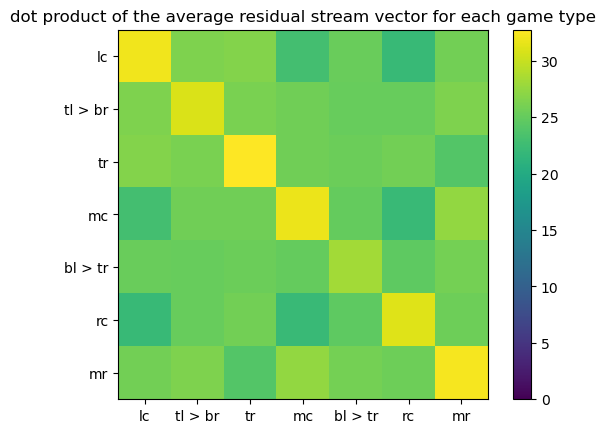

In [21]:
fig = plt.imshow(matrix @ matrix.T, vmin=0)
plt.colorbar()
plt.title("dot product of the average residual stream vector for each game type")
labels = [label_mapping[l] for l, _ in pre_mat]
positions = range(7)
plt.yticks(positions, labels)
plt.xticks(positions, labels)

([<matplotlib.axis.XTick at 0x7fc7658c9ff0>,
 [Text(0, 0, 'lc'),
  Text(1, 0, 'tl > br'),
  Text(2, 0, 'tr'),
  Text(3, 0, 'mc'),
  Text(4, 0, 'bl > tr'),
  Text(5, 0, 'rc'),
  Text(6, 0, 'mr')])

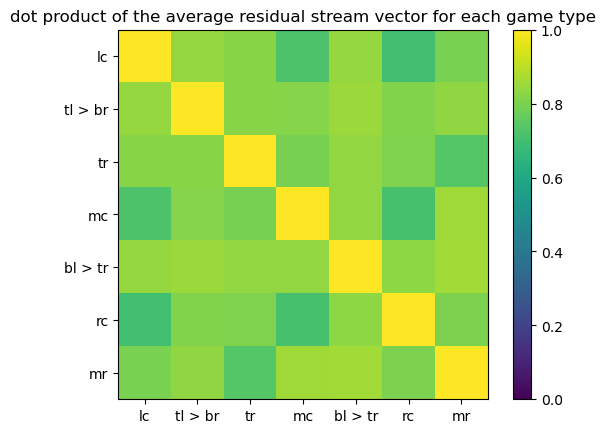

In [22]:
fig = plt.imshow(normalized_matrix @ normalized_matrix.T, vmin=0)
plt.colorbar()
plt.title("dot product of the average residual stream vector for each game type")
labels = [label_mapping[l] for l, _ in pre_mat]
positions = range(7)
plt.yticks(positions, labels)
plt.xticks(positions, labels)

In [23]:
positional_embedding_vector = model.pos_embed(torch.zeros(10), 0).detach().to("cpu")
last_pos_emb = positional_embedding_vector[0, -1, :]
last_pos_emb_normal = last_pos_emb / torch.linalg.vector_norm(last_pos_emb)

In [24]:
normalized_matrix_w_emb = torch.stack(
    [t / torch.linalg.vector_norm(t) for _, t in pre_mat] + [last_pos_emb_normal]
)

([<matplotlib.axis.XTick at 0x7fc7643062f0>,
 [Text(0, 0, 'lc'),
  Text(1, 0, 'tl > br'),
  Text(2, 0, 'tr'),
  Text(3, 0, 'mc'),
  Text(4, 0, 'bl > tr'),
  Text(5, 0, 'rc'),
  Text(6, 0, 'mr'),
  Text(7, 0, 'pos emb')])

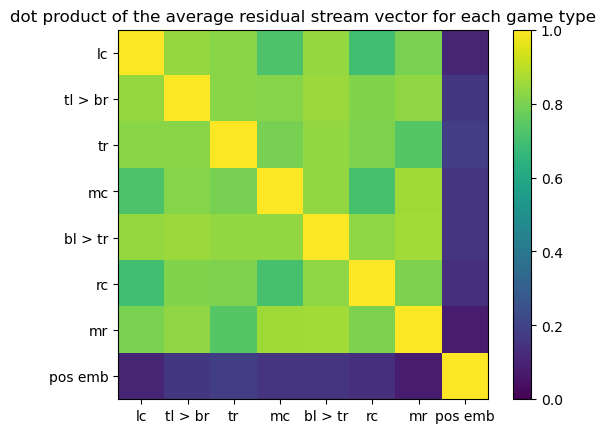

In [25]:
fig = plt.imshow(normalized_matrix_w_emb @ normalized_matrix_w_emb.T, vmin=0)
plt.colorbar()
plt.title("dot product of the average residual stream vector for each game type")
labels = [label_mapping[l] for l, _ in pre_mat] + ["pos emb"]
positions = range(len(labels))
plt.yticks(positions, labels)
plt.xticks(positions, labels)

###  double check that these vectors actually do what we think

In [26]:
def mlp_onwards(data):
    data = einops.rearrange(data, "batch resid_dim -> batch 1 resid_dim")
    out = model.blocks[0].mlp(data) @ model.W_U
    return out

In [27]:

    model.blocks[0].mlp.W_in
    model.blocks[0].mlp.act_fn
    model.blocks[0].mlp.W_out

Parameter containing:
tensor([[ 0.0041,  0.0009,  0.0156,  ...,  0.0442, -0.0292, -0.0783],
        [ 0.0379,  0.0644, -0.1435,  ..., -0.0069, -0.0238,  0.0295],
        [-0.0615,  0.0333, -0.1239,  ..., -0.0340, -0.0254, -0.0880],
        ...,
        [-0.1758,  0.0190, -0.2451,  ..., -0.0906, -0.0901, -0.0864],
        [-0.0259,  0.1256,  0.0120,  ..., -0.1833, -0.1408, -0.1433],
        [-0.0752, -0.0168,  0.0551,  ...,  0.0645,  0.0070, -0.1484]],
       device='cuda:0', requires_grad=True)

In [28]:
m = torch.cat([matrix, last_pos_emb.unsqueeze(0)]).to("cuda")

In [29]:
logit_checking = mlp_onwards(m)[:, 0]
print(logit_checking.shape)
print(torch.argmax(logit_checking, dim=1))

torch.Size([8, 10])
tensor([9, 9, 9, 9, 9, 9, 9, 9], device='cuda:0')


^ shows us these 'average' activations map to the correct output for each game type